# Sliding Window from Point Cloud (SW1PerS)
Se trata de una transformación que a partir de una función (o la imagen que lo describe) se genera un vector que recorre secciones de la serie de tiempo
$$SW_{d,\tau} f(t) = \begin{bmatrix}f(t) \\ f(t+\tau) \\ \vdots \\ f(t+d\tau)\end{bmatrix}$$
donde se mapea a $\mathbb{M}^{d+1}$ para $\mathbb{SW}_{d,\tau}f = SW_{d,\tau}f(I)$ con $I\sub \mathbb{R}$. Es decir, a una dimensión $d+1$ con paso $\tau$

In [38]:
import numpy as np
from scipy.interpolate import CubicSpline
# TDA
from Resources.SW1PerS import sliding_window as SW_
from ripser import ripser
from persim import plot_diagrams

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualización
from matplotlib import pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots


SW_S = SW_()
SW_cloud = SW_S.fit_transform

Se espera extraer las características topológiicas a partir de la forma generada por SW1PerS a partir de una serie de tiempo

The sliding window point cloud has shape (5000, 5)


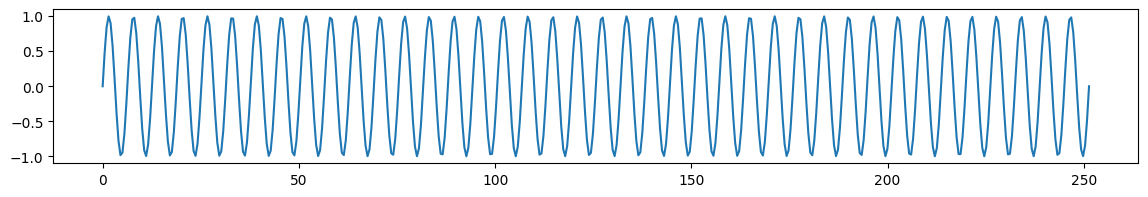

In [39]:
x_vals = np.linspace(0 , 80*np.pi, 500)
y_vals = np.sin(x_vals) #+ 1.1*np.sin(np.sqrt(3)*x_vals) + x_vals/50

plt.figure(figsize = (14,2))
plt.plot(x_vals, y_vals);

f = np.array([x_vals, y_vals])
d = 4
tau = 1.5
n_data = 5000

SW = SW_cloud(f,tau, d, n_data )
print('The sliding window point cloud has shape', SW.shape)

In [40]:
sc  = StandardScaler()
Xs = sc.fit_transform(SW)
pca = PCA(n_components=5)
SW_pca = pca.fit_transform(Xs)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,0], y=SW_pca[:,1], z=SW_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 1.5, color = 'grey')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

Explained Variance [4.29522962e-01 3.70539385e-01 1.99937653e-01 2.47803024e-10
 2.04935966e-10]


### Not Periodic VS Periodic VS Quasiperiodic

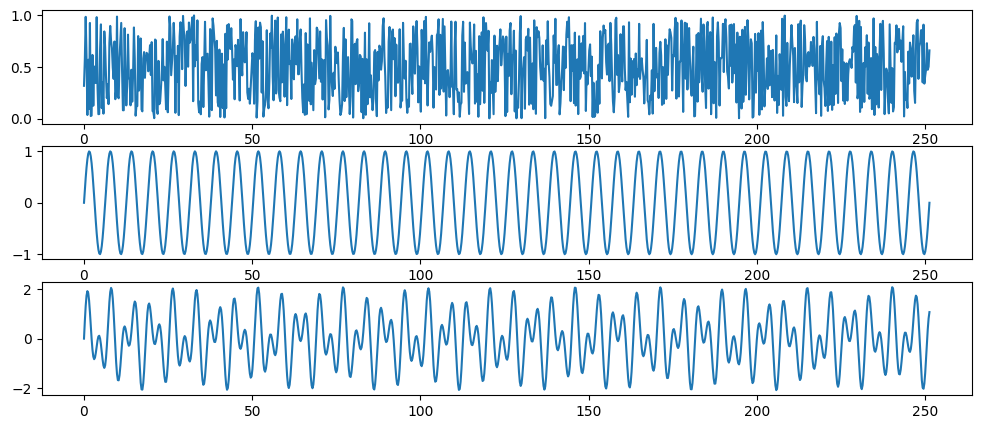

In [41]:
x_vals = np.linspace(0 , 80*np.pi, 1000)

y_not_per  = np.random.rand(len(x_vals))
y_per  = np.sin(x_vals)
y_qper  = np.sin(x_vals) + 1.1*np.sin(np.sqrt(3)*x_vals)

plt.figure(figsize = (12,5)) 
plt.subplot(3,1,1)
plt.plot(x_vals, y_not_per)

plt.subplot(3,1,2)
plt.plot(x_vals, y_per)

plt.subplot(3,1,3)
plt.plot(x_vals, y_qper)

In [42]:
import pywt

def wavelet_denoise(data, wavelet='db4', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = (pywt.threshold(c, threshold, mode="soft") for c in coeffs[1:])
    return pywt.waverec(coeffs, wavelet)

# Example usage:
# data = your time series data
# wavelet = the choice of wavelet (e.g., 'db4')
# level = the level of decomposition
denoised_data = wavelet_denoise(y_not_per, wavelet='db4', level=1)


In [43]:
# Slidng window point clouds

d = 4
tau = 1.5
n_data = 5000

f_not_per = np.array([x_vals, y_not_per])
SW_not_per = SW_cloud(f_not_per, tau, d, n_data)

f_per = np.array([x_vals, y_per])
SW_per = SW_cloud(f_per, tau, d, n_data )

f_qper = np.array([x_vals, y_qper])
SW_qper = SW_cloud(f_qper, tau, d, n_data )

In [44]:
# Persistent homology computations

n_landmarks = 200
prime_coeff = 7

rips_not_per = ripser(SW_not_per, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
dgms_not_per = rips_not_per['dgms']

rips_per = ripser(SW_per, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
dgms_per = rips_per['dgms']

rips_qper = ripser(SW_qper, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
dgms_qper = rips_qper['dgms']


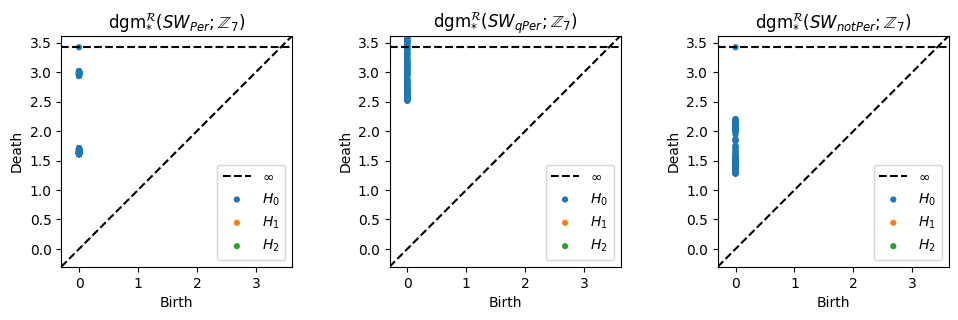

In [45]:
plt.figure(figsize = (12,3)) 
plt.subplot(1,3,1)
plot_diagrams(dgms_per)
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(SW_{Per}; \mathbb{Z}_{' + str(prime_coeff) +'})$');
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()

plt.subplot(1,3,3)
plot_diagrams(dgms_not_per, xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(SW_{notPer}; \mathbb{Z}_{' + str(prime_coeff) +'})$');

plt.subplot(1,3,2)
plot_diagrams(dgms_qper, xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(SW_{qPer}; \mathbb{Z}_{' + str(prime_coeff) +'})$');
plt.show()

In [46]:
def plot_pca_3d(data, title):
    Xs = sc.fit_transform(data)
    pca = PCA(n_components=5)
    pca_result = pca.fit_transform(Xs)

    print('Explained Variance', pca.explained_variance_ratio_)

    fig = go.Figure(data=[go.Scatter3d(x=pca_result[:, 0], y=pca_result[:, 1], z=pca_result[:, 2], mode ='markers', 
    marker=dict(size = 1.5, color = 'grey'))])
    fig.update_layout(title=title)
    fig.show()

plot_pca_3d(SW_not_per, title='PCA Plot - Not periodic')
plot_pca_3d(SW_qper, title='PCA Plot - Quasi periodic')
plot_pca_3d(SW_per, title='PCA Plot - Periodic')

Explained Variance [0.21240939 0.20728481 0.20363673 0.19642797 0.1802411 ]


Explained Variance [0.31187531 0.2797402  0.19983768 0.18975371 0.01879311]


Explained Variance [4.29522264e-01 3.70540067e-01 1.99937669e-01 4.67091613e-13
 3.62910323e-13]


## Maximum persistence as periodicity score

$$
mp_1 = \max \big\{ b - a \; : \; (a,b) \in \mathsf{dgm}_1(\mathcal{R}(\mathbb{SW}_{d,\tau} f))\big\}
$$


In [47]:
def compute_and_print_max_pers(data, label):
    mp_1_value = SW_S.max_pers(data, dim = 1)
    print(f"{label} mp_1:", mp_1_value)

compute_and_print_max_pers(SW_not_per, "Not periodic")
compute_and_print_max_pers(SW_qper, "Quasiperiodic")
compute_and_print_max_pers(SW_per, "Periodic")

Not periodic mp_1: 0
Quasiperiodic mp_1: 0.5708866119384766
Periodic mp_1: 0


Entonces, esto da pie a la clasificación de la periocidad de una serie de tiempo con una interpretación geométrica